Import all necessary libraries and install everything you need for training:

Before starting, click on the "RAM" and "Disk" information on the top right part of the page and click "Change runtime type" > Choose "GPU" as "Hardware accelerator".

In [1]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import time
from sklearn.metrics import classification_report

In [ ]:
# Install transformers
# (this needs to be done on Colab each time you start the session)
!pip install -q transformers

# Install the simpletransformers
!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

In [ ]:
# Install wandb
!pip install -q wandb

import wandb

# Login to wandb
wandb.login()

### Import the data

In [7]:
Colab_path = "/content"

train_df = pd.read_csv(f"{Colab_path}/SLED-for-Transformers-train.csv", sep="\t", index_col=0)
dev_df = pd.read_csv(f"{Colab_path}/SLED-for-Transformers-dev.csv", sep="\t", index_col = 0)
test_df = pd.read_csv(f"{Colab_path}/SLED-for-Transformers-test.csv", sep="\t", index_col = 0)

print("Train shape: {}, Dev shape: {}, Test shape: {}.".format(train_df.shape, dev_df.shape, test_df.shape))

Train shape: (9990, 2), Dev shape: (1296, 2), Test shape: (1299, 2).


In [8]:
train_df.head()

,text,labels
0,na tolminskem se je dopoldne zgodila prometna ...,crnakronika
1,na cesti zadlaz-žabče se je zgodila prometna n...,crnakronika
2,v sredo ob 1321 je bila novogoriška policija o...,crnakronika
3,malo po 16 uri je v svetem duhu na ostrem vrhu...,crnakronika
4,v eksploziji pirotehnike je bil v soboto popol...,crnakronika


## Training and saving

We will use the multilingual XLM-RoBERTa model
https://huggingface.co/xlm-roberta-base

In [5]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [9]:
# Create a list of labels
LABELS = train_df.labels.unique().tolist()
LABELS

['crnakronika',
 'druzba',
 'gospodarstvo',
 'izobrazevanje',
 'kultura',
 'okolje',
 'politika',
 'prosticas',
 'sport',
 'vreme',
 'zabava',
 'zdravje',
 'znanost']

In [ ]:
# Initialize Wandb
wandb.init(project="SLED-categorization", entity="tajak", name="XLM-RoBERTa-hyperparameter-search")

In [10]:
# Calculate how many steps will each epoch have
# Num steps in epoch = training samples / batch size
steps_per_epoch = int(9990/8)
steps_per_epoch

1248

### Hyperparameter search

I evaluated per every 10th epoch - per 12480  steps. I first trained the model while evaluating it to find the optimal number of epochs and then trained it again and saved it.

In [ ]:
# Create a TransformerModel
roberta_base_model = ClassificationModel(
        "xlmroberta", "xlm-roberta-base",
        num_labels=len(LABELS),
        use_cuda=True,
        args= {
            "overwrite_output_dir": True,
            "num_train_epochs": 30,
            "train_batch_size":8,
            "learning_rate": 1e-5,
            # Use these parameters if you want to evaluate during training
            "evaluate_during_training": True,
            "evaluate_during_training_steps": steps_per_epoch*10,
            "evaluate_during_training_verbose": True,
            "use_cached_eval_features": True,
            'reprocess_input_data': True,
            "labels_list": LABELS,
            "no_cache": True,
            # Disable no_save: True if you want to save the model
            "no_save": True,
            "max_seq_length": 512,
            "save_steps": -1,
            # Only the trained model will be saved - to prevent filling all of the space
            "save_model_every_epoch":False,
            "wandb_project": 'SLED-categorization',
            "silent": True,
            }
        )

In [ ]:
# Train the model
training_start_time = time.time()
roberta_base_model.train_model(train_df, eval_df = dev_df)

print(f"Training and evaluation took {round((time.time() - training_start_time)/60,2)} minutes.")

Based on evaluation during training, the optimum epoch is between 2 and 6 epochs.

In [10]:
previous_results = []

In [13]:
def testing(test_df, test_name, epoch):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - test_df (pandas DataFrame)
    - test_name
    - epoch: num_train_epochs
    """
    # Get the true labels
    y_true = test_df.labels

    model = roberta_base_model
    
    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"{test_name}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"Confusion-matrix-{test_name}.png",dpi=100)

    # Add classification report
    print(classification_report(y_true, y_pred, labels = LABELS))

    # Save the results:
    rezdict = {
        "experiment": test_name,
        "num_train_epochs": epoch,
        "train_batch_size":8,
        "learning_rate": 1e-5,
        "microF1": micro,
        "macroF1": macro,
        "y_true": y_true.to_dict(),
        "y_pred": y_pred.to_dict(),
        }
    previous_results.append(rezdict)

    #Save intermediate results (just in case)
    backup = []
    backup.append(rezdict)
    with open(f"backup-results-{test_name}.json", "w") as backup_file:
        json.dump(backup,backup_file, indent= "")

In [ ]:
# Train the model for various epochs to find the optimum number
#epochs = [2, 4, 6]
epochs = [6, 8]

for epoch in epochs:
    roberta_base_model = ClassificationModel(
                "xlmroberta", "xlm-roberta-base",
                num_labels=len(LABELS),
                use_cuda=True,
                args= {
                    "overwrite_output_dir": True,
                    "num_train_epochs": epoch,
                    "train_batch_size":8,
                    "learning_rate": 1e-5,
                    "labels_list": LABELS,
                    # The following parameters (no_cache, no_save) are commented out if I want to save the model
                    "no_cache": True,
                    # Disable no_save: True if you want to save the model
                    "no_save": True,
                    "max_seq_length": 512,
                    "save_steps": -1,
                    # Only the trained model will be saved - to prevent filling all of the space
                    "save_model_every_epoch":False,
                    "wandb_project": 'SLED-categorization',
                    "silent": True,
                    }
                )

    # Train the model
    roberta_base_model.train_model(train_df)
    
    # Test the model on dev_df
    testing(dev_df, f"SLED-trainsmall-XLM-RoBERTa-dev-epoch-search:{epoch}", epoch)

Optimum number of epochs was revealed to be 6.

In [ ]:
# Compare the results by creating a dataframe from the previous_results dictionary:
results_df = pd.DataFrame(previous_results)

results_df

In [ ]:
# Save the file with updated results.
with open("SLED-XLM-RoBERTa-trainsmall-hyperparameter-search-Results.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

In [ ]:
# Create a TransformerModel
roberta_base_model = ClassificationModel(
        "xlmroberta", "xlm-roberta-base",
        num_labels=len(LABELS),
        use_cuda=True,
        args= {
            "overwrite_output_dir": True,
            "num_train_epochs": 6,
            "train_batch_size":8,
            "learning_rate": 1e-5,
            "labels_list": LABELS,
            # The following parameters are commented out because I want to save the model
            #"no_cache": True,
            # Disable no_save: True if you want to save the model
            #"no_save": True,
            "max_seq_length": 512,
            "save_steps": -1,
            # Only the trained model will be saved - to prevent filling all of the space
            "save_model_every_epoch":False,
            "wandb_project": 'SLED-categorization',
            "silent": True,
            }
        )

In [ ]:
# Train the model
roberta_base_model.train_model(train_df)

In [ ]:
# Save the trained model to Wandb
run = wandb.init(project="SLED-categorization", entity="tajak", name="saving-trained-model")
trained_model_artifact = wandb.Artifact("SLED-XLM-RoBERTa-trainsmall-classifier", type="model", description="a XLM-RoBERTa model fine-tuned on the SLED trainsmall dataset.")
trained_model_artifact.add_dir("/kaggle/working/outputs")
run.log_artifact(trained_model_artifact)

## Testing the model

In [6]:
# Download the saved model

# Initialize Wandb
run = wandb.init(project="SLED-categorization", entity="tajak", name="testing-trained-model")

# Load the saved model
artifact = run.use_artifact('tajak/SLED-categorization/SLED-XLM-RoBERTa-trainsmall-classifier:v0', type='model')
artifact_dir = artifact.download()

# Loading a local save
roberta_base_model = ClassificationModel(
    "xlmroberta", artifact_dir)

wandb: Currently logged in as: tajak. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact SLED-XLM-RoBERTa-trainsmall-classifier:v0, 1081.89MB. 8 files... Done. 0:0:11.7
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:476: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  f"use_multiprocessing automatically disabled as {model_type}"


In [11]:
# Create a list to save results into
previous_results = []

Macro f1: 0.905, Micro f1: 0.906


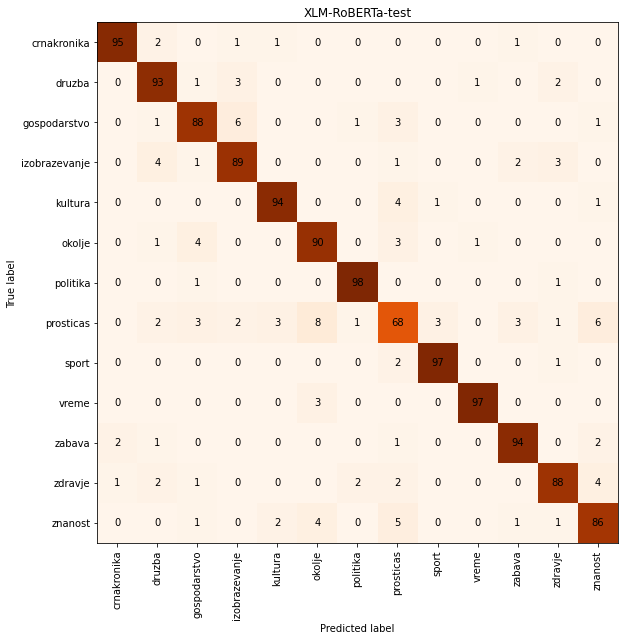

               precision    recall  f1-score   support

  crnakronika       0.97      0.95      0.96       100
       druzba       0.88      0.93      0.90       100
 gospodarstvo       0.88      0.88      0.88       100
izobrazevanje       0.88      0.89      0.89       100
      kultura       0.94      0.94      0.94       100
       okolje       0.86      0.91      0.88        99
     politika       0.96      0.98      0.97       100
    prosticas       0.76      0.68      0.72       100
        sport       0.96      0.97      0.97       100
        vreme       0.98      0.97      0.97       100
       zabava       0.93      0.94      0.94       100
      zdravje       0.91      0.88      0.89       100
      znanost       0.86      0.86      0.86       100

     accuracy                           0.91      1299
    macro avg       0.91      0.91      0.91      1299
 weighted avg       0.91      0.91      0.91      1299



<Figure size 432x288 with 0 Axes>

In [14]:
# Test the model on the test split
testing(test_df, "XLM-RoBERTa-test", 6)

In [15]:
results_df = pd.DataFrame(previous_results)

results_df

,experiment,num_train_epochs,train_batch_size,learning_rate,microF1,macroF1,y_true,y_pred
0,XLM-RoBERTa-test,6,8,0.00001,0.906082,0.905314,"{0: 'crnakronika', 1: 'crnakronika', 2: 'crnak...","{0: 'crnakronika', 1: 'crnakronika', 2: 'crnak..."


In [16]:
# Save the results
with open("XLM-RoBERTa-SLED-trainsmall-experiments-Results.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")